# β-VAE (Beta-Variational Autoencoder) para Clasificación AD vs CN
## Ejemplo Educativo (Toy Example)

**Objetivo del notebook:** Comprender el pipeline completo β-VAE + clasificador clásico para distinguir entre pacientes con Alzheimer (AD) y controles sanos (CN) usando matrices de conectividad fMRI simuladas.

### Estructura del notebook
1. Generación de datos sintéticos (sin necesidad de descargar el dataset ADNI)
2. Arquitectura del Encoder y el Decoder (CNN con GroupNorm)
3. Función de pérdida ELBO / β-VAE
4. Bucle de entrenamiento PyTorch (sin K-Fold, split 80/20)
5. Extracción de representaciones latentes
6. Clasificadores clásicos: Logistic Regression y SVM
7. Visualizaciones: espacio latente (PCA / t-SNE) y curva ROC

> **Nota pedagógica:** Este notebook es una versión simplificada del pipeline de investigación `scripts/run_vae_clf_ad_inference.py`. Se eliminaron: validación cruzada K-Fold, logging (WandB/MLflow), manejo de artefactos complejos y tests de permutación, para centrarse en la arquitectura fundamental.


## 0. Importaciones y configuración


In [1]:
# --- Instalación rápida (ejecutar solo una vez si faltan paquetes) ---
# !pip install torch numpy matplotlib scikit-learn

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

# Reproducibilidad global
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo: {device}')


Dispositivo: cuda


## 1. Generación de Datos Sintéticos

Los datos reales del estudio son **matrices de conectividad funcional** (fMRI), representadas como tensores de forma `(N_sujetos, C_canales, ROIs, ROIs)`.

Para este ejemplo usamos **1 canal**: la **matriz de correlación de Pearson** entre regiones de interés (ROIs) del atlas AAL3.

### Geometría del tensor

| Dimensión | Descripción | Valor (toy) |
|-----------|-------------|-------------|
| N | Número de sujetos | 200 |
| C | Canales (solo Pearson) | 1 |
| H = W | ROIs × ROIs (imagen cuadrada) | 131 × 131 |

### Simulación de señal biológica

Para que el clasificador tenga algo que aprender, añadimos una **diferencia sistemática** entre AD y CN en un bloque de la matriz (simulando hipoperfusión en AD).


In [2]:
import pandas as pd

# ── Parámetros del dataset real ──────────────────────────────────────────
# Rutas a los datos (ajustar a las rutas locales de los alumnos)
TENSOR_PATH = "/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
METADATA_PATH = "/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv"
LATENT_DIM = 32

# El canal Pearson_Full_FisherZ_Signed suele ser el índice 1 en tu tensor
TARGET_CHANNEL_IDX = 1  

# ── 1. Cargar y alinear datos ────────────────────────────────────────────
# Cargamos el tensor y los IDs de los sujetos
data_npz = np.load(TENSOR_PATH, allow_pickle=True)
global_tensor = data_npz['global_tensor_data'] 
subject_ids_tensor = data_npz['subject_ids'].astype(str)

# Creamos un DataFrame puente para vincular el índice del tensor con el ID del sujeto
tensor_df = pd.DataFrame({
    'SubjectID': subject_ids_tensor, 
    'tensor_idx': np.arange(len(subject_ids_tensor))
})

# Cargamos variables clínicas y cruzamos con el tensor
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df['SubjectID'] = metadata_df['SubjectID'].astype(str).str.strip()

merged_df = pd.merge(tensor_df, metadata_df, on='SubjectID', how='inner')

# Filtramos solo Alzheimer (AD) y Controles Sanos (CN)
cn_ad_df = merged_df[merged_df['ResearchGroup_Mapped'].isin(['CN', 'AD'])].copy()
cn_ad_df['label'] = cn_ad_df['ResearchGroup_Mapped'].map({'CN': 0, 'AD': 1})

valid_indices = cn_ad_df['tensor_idx'].values
y_all = cn_ad_df['label'].values

# ── 2. Extracción del canal específico ───────────────────────────────────
# Cortamos el tensor: (Sujetos_CN_AD, Canal_1_a_2, ROIs, ROIs)
# Usar 1:2 mantiene la dimensión del canal (C=1) para que el CNN no falle
X_all = global_tensor[valid_indices, TARGET_CHANNEL_IDX:TARGET_CHANNEL_IDX+1, :, :]

IMG_SIZE = X_all.shape[-1] # Se ajustará dinámicamente a 131 (AAL3)
N_CHANNELS = 1

print(f'Tensor de entrada extraído: {X_all.shape}  (N, C, H, W)')
print(f'Etiquetas reales: {np.bincount(y_all)}  (CN=0, AD=1)')

#print(f'Tensor de entrada: {X_all.shape}  (N, C, H, W)')
#print(f'Etiquetas: {np.bincount(y_all)}  (CN=0, AD=1)')

# ── Normalización por sujeto (Z-score) ───────────────────────────────────
X_norm = (X_all - X_all.mean(axis=(1,2,3), keepdims=True)) / \
         (X_all.std(axis=(1,2,3), keepdims=True) + 1e-6)

# ── Split 80 / 20 estratificado ───────────────────────────────────────────
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_norm, y_all, test_size=0.2, stratify=y_all, random_state=SEED
)

print(f'\nTrain: {X_train_np.shape[0]} sujetos  |  Test: {X_test_np.shape[0]} sujetos')
print(f'Train CN/AD: {np.bincount(y_train_np)}  |  Test CN/AD: {np.bincount(y_test_np)}')

# ── DataLoaders ───────────────────────────────────────────────────────────
BATCH_SIZE   = 32
train_ds     = TensorDataset(torch.from_numpy(X_train_np))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)


Tensor de entrada extraído: (184, 1, 131, 131)  (N, C, H, W)
Etiquetas reales: [89 95]  (CN=0, AD=1)

Train: 147 sujetos  |  Test: 37 sujetos
Train CN/AD: [71 76]  |  Test CN/AD: [18 19]


## 2. Arquitectura del β-VAE

### 2.1 Visión general

El β-VAE es un **autoencoder variacional con restricción aumentada sobre el espacio latente**, útil para aprender representaciones *disentangled* de datos complejos.

```
Entrada x              Espacio latente z              Reconstrucción x̂
(1 × 131 × 131) ──Enc──► (μ, log σ²) ──Reparam──► z ──Dec──► (1 × 131 × 131)
```

### 2.2 Encoder

Aplica convoluciones sucesivas para comprimir `(C, H, W)` en dos vectores:
- **μ** (media): coordenada central en el espacio latente.
- **log σ²** (log-varianza): incertidumbre de la representación.

### 2.3 El Truco de Reparametrización

Para poder calcular gradientes a través de una operación estocástica:

$$z = \mu + \sigma \odot \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, I)$$

Esto convierte el muestreo (no diferenciable) en una operación determinista sobre $\varepsilon$, permitiendo que los gradientes fluyan hacia el Encoder.

### 2.4 Decoder

Recibe $z$ y lo descomprime con capas `ConvTranspose2d` hasta reconstruir la imagen original.


In [3]:
class BetaVAE(nn.Module):
    """
    beta-VAE convolucional simplificado para matrices de conectividad fMRI.

    Arquitectura:
        Encoder: 3 bloques Conv2d  -> [mu, log sigma^2]
        Decoder: FC -> 3 bloques ConvTranspose2d -> reconstruccion
    """

    def __init__(self, in_channels: int = 1, latent_dim: int = 32, img_size: int = 131):
        super().__init__()
        self.latent_dim = latent_dim

        # ── ENCODER ──────────────────────────────────────────────────────
        # Cada bloque: Conv2d + GELU (activacion suave) + GroupNorm + Dropout2d
        # GroupNorm: mas estable que BatchNorm con batch pequeno
        self.encoder = nn.Sequential(
            # Bloque 1: (1, 131, 131) -> (32, ~65, ~65)
            nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=1),
            nn.GELU(),
            nn.GroupNorm(8, 32),
            nn.Dropout2d(0.1),

            # Bloque 2: (32, ~31, ~31) -> (64, ~15, ~15)
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.GELU(),
            nn.GroupNorm(8, 64),
            nn.Dropout2d(0.1),

            # Bloque 3: (64, ~15, ~15) -> (128, ~7, ~7)
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1),
            nn.GELU(),
            nn.GroupNorm(8, 128),
        )

        # Calcular el tamano del feature map aplanado tras el encoder
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_size, img_size)
            enc_out = self.encoder(dummy)
            self._flat_size = enc_out.view(1, -1).shape[1]
            self._enc_shape  = enc_out.shape[1:]  # (C, H, W) del feature map

        # Capas lineales que producen mu y log sigma^2
        self.fc_mu     = nn.Linear(self._flat_size, latent_dim)
        self.fc_logvar = nn.Linear(self._flat_size, latent_dim)

        # ── DECODER ──────────────────────────────────────────────────────
        # FC que proyecta z de vuelta al tamano del feature map del encoder
        self.dec_fc = nn.Linear(latent_dim, self._flat_size)

        self.decoder = nn.Sequential(
            # Bloque 1: (128, ~7, ~7) -> (64, ~15, ~15)
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.GELU(),
            nn.GroupNorm(8, 64),
            nn.Dropout2d(0.1),

            # Bloque 2: (64, ~15, ~15) -> (32, ~31, ~31)
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.GELU(),
            nn.GroupNorm(8, 32),
            nn.Dropout2d(0.1),

            # Bloque 3: (32, ~31, ~31) -> (1, 64, 64)
            nn.ConvTranspose2d(32, in_channels, kernel_size=5, stride=2, padding=1, output_padding=1),
            # Tanh: salida en [-1,1], coherente con la normalizacion Z-score de entrada
            nn.Tanh(),
        )

    def encode(self, x):
        """Encoder: imagen -> (mu, log sigma^2)"""
        h = self.encoder(x)        # extrae features convolucionales
        h = h.view(h.size(0), -1)  # aplanar (flatten)
        return self.fc_mu(h), self.fc_logvar(h)

    @staticmethod
    def reparameterize(mu, logvar):
        """
        Truco de reparametrizacion: z = mu + sigma * eps,  eps ~ N(0, I)

        CLAVE para backprop:
        - El muestreo 'eps ~ N(0,I)' no tiene gradiente.
        - Al expresar z = mu + sigma*eps, los gradientes
          fluyen hacia mu y logvar sin problema.
        """
        std = torch.exp(0.5 * logvar)   # sigma = exp(log sigma^2 / 2)
        eps = torch.randn_like(std)     # eps ~ N(0, I)
        return mu + eps * std           # z ~ N(mu, sigma^2 * I)

    def decode(self, z):
        """Decoder: z -> imagen reconstruida"""
        h = self.dec_fc(z)                       # proyeccion FC
        h = h.view(h.size(0), *self._enc_shape)  # reshape a feature map
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        # NOTA EDUCATIVA: 
        # Nuestro atlas tiene 131 ROIs. Al pasar por 3 capas de stride=2, 
        # la dimension baja a 17x17. Al reconstruir, sube a 129x129.
        # Usamos interpolación bilineal para ajustar esos 2 pixeles faltantes y volver a 131x131.
        if recon_x.shape != x.shape:
            recon_x = nn.functional.interpolate(
                recon_x, size=x.shape[2:], mode='bilinear', align_corners=False
            )
        return recon_x, mu, logvar, z


# Instanciar y mover al dispositivo
model = BetaVAE(in_channels=N_CHANNELS, latent_dim=LATENT_DIM, img_size=IMG_SIZE).to(device)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Parametros entrenables: {n_params:,}')
print(model)


Parametros entrenables: 3,308,225
BetaVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): GroupNorm(8, 32, eps=1e-05, affine=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): GroupNorm(8, 64, eps=1e-05, affine=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): GroupNorm(8, 128, eps=1e-05, affine=True)
  )
  (fc_mu): Linear(in_features=28800, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=28800, out_features=32, bias=True)
  (dec_fc): Linear(in_features=32, out_features=28800, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): GroupNorm(8, 6

## 3. Función de Pérdida: ELBO y β-VAE

### 3.1 Objetivo variacional (ELBO)

El VAE maximiza la **Evidencia del Límite Inferior** (ELBO):

$$\mathcal{L}_{\text{ELBO}} = \underbrace{\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]}_{\text{Reconstrucción}} - \underbrace{D_{\text{KL}}\left(q_\phi(z|x) \| p(z)\right)}_{\text{Regularización KL}}$$

donde:
- $q_\phi(z|x) = \mathcal{N}(z;\,\mu_\phi(x), \sigma^2_\phi(x)\,I)$ es el **encoder**.
- $p_\theta(x|z)$ es el **decoder** (verosimilitud de reconstrucción).
- $p(z) = \mathcal{N}(0, I)$ es la prior estándar.

### 3.2 El β-VAE

Higgins et al. (2017) propusieron añadir $\beta > 1$ para fomentar representaciones *disentangled*:

$$\mathcal{L}_{\beta\text{-VAE}} = \underbrace{\mathbb{E}\left[\| x - \hat{x} \|^2_2\right]}_{\text{MSE}} + \beta \cdot \underbrace{D_{\text{KL}}\left(q_\phi(z|x) \| p(z)\right)}_{\text{KL}}$$

La **Divergencia KL** tiene forma analítica para gaussianas:

$$D_{\text{KL}}\left(\mathcal{N}(\mu, \sigma^2) \| \mathcal{N}(0, 1)\right) = -\frac{1}{2} \sum_{j=1}^{d} \left(1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2\right)$$

### 3.3 Interpretación de β

| β | Efecto |
|---|--------|
| β = 0 | Autoencoder determinista (sin regularización) |
| β = 1 | VAE estándar (equilibrio reconstrucción/KL) |
| β > 1 | **β-VAE**: penaliza más la KL → espacio latente más compacto y organizado |


In [4]:
def beta_vae_loss(recon_x, x, mu, logvar, beta: float = 1.0):
    """
    Funcion de perdida del beta-VAE.

    Args:
        recon_x : reconstruccion del decoder, shape (B, C, H, W)
        x       : imagen original,            shape (B, C, H, W)
        mu      : media del encoder,           shape (B, latent_dim)
        logvar  : log-varianza del encoder,    shape (B, latent_dim)
        beta    : hiperparametro de regularizacion (beta=1 -> VAE clasico)
    Returns:
        (total_loss, recon_loss, kld_loss) como escalares
    """
    # Perdida de Reconstruccion: MSE promediado por muestra
    # sum() sobre pixeles, mean() (via /B) sobre el batch -> escala consistente
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)

    # Divergencia KL: forma analitica para gaussianas
    # -0.5 * sum_j (1 + log sigma_j^2 - mu_j^2 - sigma_j^2)
    kld_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp(), dim=1
    ).mean()

    total_loss = recon_loss + beta * kld_loss
    return total_loss, recon_loss.detach(), kld_loss.detach()


# Hiperparametros
BETA         = 4.0    # beta > 1 fomenta disentanglement
LR           = 1e-3
EPOCHS       = 150
WEIGHT_DECAY = 1e-4

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# Scheduler coseno: reduce LR suavemente hacia el final
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

print(f'beta = {BETA}  |  LR = {LR}  |  Epocas = {EPOCHS}')


beta = 4.0  |  LR = 0.001  |  Epocas = 150


## 4. Entrenamiento del β-VAE

El bucle de entrenamiento sigue el ciclo estándar de PyTorch:

1. **Forward pass:** batch → `(recon_x, μ, log σ², z)`.
2. **Calcular pérdida:** ELBO con β.
3. **Backward pass:** gradientes con `.backward()`.
4. **Optimizer step:** actualizar pesos con AdamW.

> Sin K-Fold aquí: el modelo se entrena una sola vez sobre el 80% de los datos.


In [5]:
history = {'train_loss': [], 'train_recon': [], 'train_kld': []}

print(f"{'Epoch':>6}  {'Train Loss':>12}  {'Recon':>10}  {'KLD':>10}  {'LR':>10}")
print('-' * 60)

for epoch in range(1, EPOCHS + 1):
    model.train()
    ep_loss, ep_recon, ep_kld = 0.0, 0.0, 0.0

    for (batch,) in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad(set_to_none=True)   # limpiar gradientes acumulados

        # Forward: encoder -> reparametrize -> decoder
        recon, mu, logvar, z = model(batch)

        # Perdida beta-VAE
        loss, recon_l, kld_l = beta_vae_loss(recon, batch, mu, logvar, beta=BETA)

        loss.backward()  # calcular gradientes
        # Gradient clipping: evita explosion de gradientes en las primeras epocas
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # actualizar pesos

        n = batch.size(0)
        ep_loss  += loss.item()    * n
        ep_recon += recon_l.item() * n
        ep_kld   += kld_l.item()   * n

    scheduler.step()

    N = len(train_loader.dataset)
    history['train_loss'].append(ep_loss  / N)
    history['train_recon'].append(ep_recon / N)
    history['train_kld'].append(ep_kld   / N)

    if epoch % 10 == 0 or epoch == 1:
        lr_now = optimizer.param_groups[0]['lr']
        print(f"{epoch:>6}  {history['train_loss'][-1]:>12.4f}  "
              f"{history['train_recon'][-1]:>10.4f}  "
              f"{history['train_kld'][-1]:>10.4f}  "
              f"{lr_now:>10.2e}")

print('\n Entrenamiento completado.')


 Epoch    Train Loss       Recon         KLD          LR
------------------------------------------------------------
     1    51153.4477  19868.6127   7821.2089    1.00e-03
    10    10080.7828   9645.7451    108.7594    9.89e-04
    20     8659.4793   8387.9877     67.8730    9.57e-04
    30     8013.4361   7720.4408     73.2488    9.05e-04
    40     7621.9786   7328.9237     73.2637    8.36e-04
    50     7320.1698   7025.3610     73.7022    7.52e-04
    60     7118.3627   6822.3044     74.0146    6.58e-04
    70     6907.7235   6616.7910     72.7331    5.57e-04
    80     6792.7412   6508.2683     71.1182    4.53e-04
    90     6706.5653   6423.0962     70.8673    3.52e-04
   100     6644.2135   6359.6327     71.1452    2.57e-04
   110     6588.6328   6302.0510     71.6455    1.74e-04
   120     6518.7737   6239.2403     69.8834    1.05e-04
   130     6495.1624   6216.4855     69.6692    5.28e-05
   140     6465.3000   6188.3913     69.2272    2.08e-05
   150     6471.6481   6197

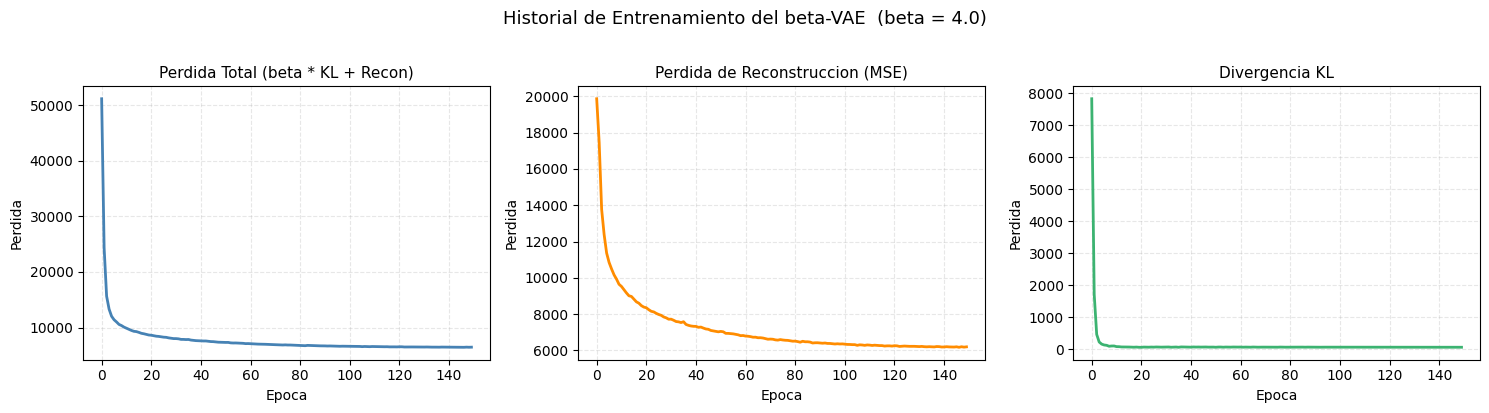

Curvas guardadas en betavae_training_curves.png


In [6]:
# ── Curvas de aprendizaje ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

specs = [
    ('train_loss',  'Perdida Total (beta * KL + Recon)', 'steelblue'),
    ('train_recon', 'Perdida de Reconstruccion (MSE)',   'darkorange'),
    ('train_kld',   'Divergencia KL',                    'mediumseagreen'),
]

for ax, (key, title, color) in zip(axes, specs):
    ax.plot(history[key], color=color, linewidth=2)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Epoca')
    ax.set_ylabel('Perdida')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle(f'Historial de Entrenamiento del beta-VAE  (beta = {BETA})',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('betavae_training_curves.png', dpi=120, bbox_inches='tight')
plt.show()
print('Curvas guardadas en betavae_training_curves.png')


## 5. Extracción de Representaciones Latentes

Una vez entrenado el VAE, usamos el **Encoder** para mapear cada sujeto a su vector latente **μ**.

¿Por qué **μ** y no **z**?  
- **z** incluye ruido del truco de reparametrización → variabilidad extra.  
- **μ** es la estimación puntual de la media posterior → más estable para clasificación downstream.

$$\mu_{\text{subj}} = \text{Encoder}(x_{\text{subj}}) \in \mathbb{R}^{d_z}$$


In [7]:
def extract_latents(model, X_np, batch_size=64):
    """Extrae los vectores mu del encoder para todos los sujetos."""
    model.eval()
    mu_list = []
    with torch.no_grad():
        for i in range(0, len(X_np), batch_size):
            batch = torch.from_numpy(X_np[i:i+batch_size]).to(device)
            mu, _ = model.encode(batch)  # solo mu, descartamos logvar
            mu_list.append(mu.cpu().numpy())
    return np.concatenate(mu_list, axis=0)


Z_train = extract_latents(model, X_train_np)
Z_test  = extract_latents(model, X_test_np)

print(f'Latentes TRAIN: {Z_train.shape}  (N_train x latent_dim)')
print(f'Latentes TEST:  {Z_test.shape}   (N_test  x latent_dim)')
print(f'\nMedias de mu (primeras 5 dims): {Z_train.mean(0)[:5].round(3)}')
print(f'Desv. estandar de mu (primeras 5 dims): {Z_train.std(0)[:5].round(3)}')


Latentes TRAIN: (147, 32)  (N_train x latent_dim)
Latentes TEST:  (37, 32)   (N_test  x latent_dim)

Medias de mu (primeras 5 dims): [0.712 0.694 0.149 0.482 0.23 ]
Desv. estandar de mu (primeras 5 dims): [0.933 1.126 1.494 1.222 1.134]


## 6. Clasificadores Clásicos sobre el Espacio Latente

Entrenamos dos clasificadores sobre los vectores μ:

1. **Regresión Logística (LogReg):** modelo lineal, interpretable.
   $$P(AD | \mu) = \sigma(W \cdot \mu + b), \quad \sigma(x) = \frac{1}{1 + e^{-x}}$$

2. **Support Vector Machine (SVM-RBF):** no lineal con kernel RBF, útil cuando las clases no son linealmente separables en el espacio latente.

### Escalado previo

Los clasificadores sensibles a distancias necesitan features en la misma escala. Aplicamos `StandardScaler` ajustado **solo** con datos de entrenamiento (para evitar data leakage).


In [8]:
# ── Escalar representaciones latentes ────────────────────────────────────
scaler = StandardScaler()
Z_train_sc = scaler.fit_transform(Z_train)  # fit + transform en TRAIN
Z_test_sc  = scaler.transform(Z_test)        # solo transform en TEST

# ── Regresion Logistica ───────────────────────────────────────────────────
logreg = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000,
                             random_state=SEED)
logreg.fit(Z_train_sc, y_train_np)

y_prob_lr = logreg.predict_proba(Z_test_sc)[:, 1]
y_pred_lr = logreg.predict(Z_test_sc)

auc_lr = roc_auc_score(y_test_np, y_prob_lr)
acc_lr = accuracy_score(y_test_np, y_pred_lr)
print(f'Logistic Regression  ->  AUC: {auc_lr:.3f}  |  Accuracy: {acc_lr:.3f}')

# ── SVM con kernel RBF ────────────────────────────────────────────────────
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,
              random_state=SEED)
svm_clf.fit(Z_train_sc, y_train_np)

y_prob_sv = svm_clf.predict_proba(Z_test_sc)[:, 1]
y_pred_sv = svm_clf.predict(Z_test_sc)

auc_sv = roc_auc_score(y_test_np, y_prob_sv)
acc_sv = accuracy_score(y_test_np, y_pred_sv)
print(f'SVM (RBF)            ->  AUC: {auc_sv:.3f}  |  Accuracy: {acc_sv:.3f}')


Logistic Regression  ->  AUC: 0.792  |  Accuracy: 0.703
SVM (RBF)            ->  AUC: 0.749  |  Accuracy: 0.676


## 7. Visualizaciones

### 7.1 Espacio Latente (PCA y t-SNE)

Proyectamos los vectores μ a 2D para inspeccionar la separabilidad entre AD y CN:

- **PCA:** proyección lineal global (rápida).
- **t-SNE:** proyección no lineal que preserva estructura local (más informativa).

### 7.2 Curva ROC

Muestra el tradeoff entre **Sensibilidad** (TPR) y **1 - Especificidad** (FPR) para todos los umbrales de decisión. El **AUC** (Área Bajo la Curva) resume el rendimiento en un solo número (1.0 = perfecto, 0.5 = azar).


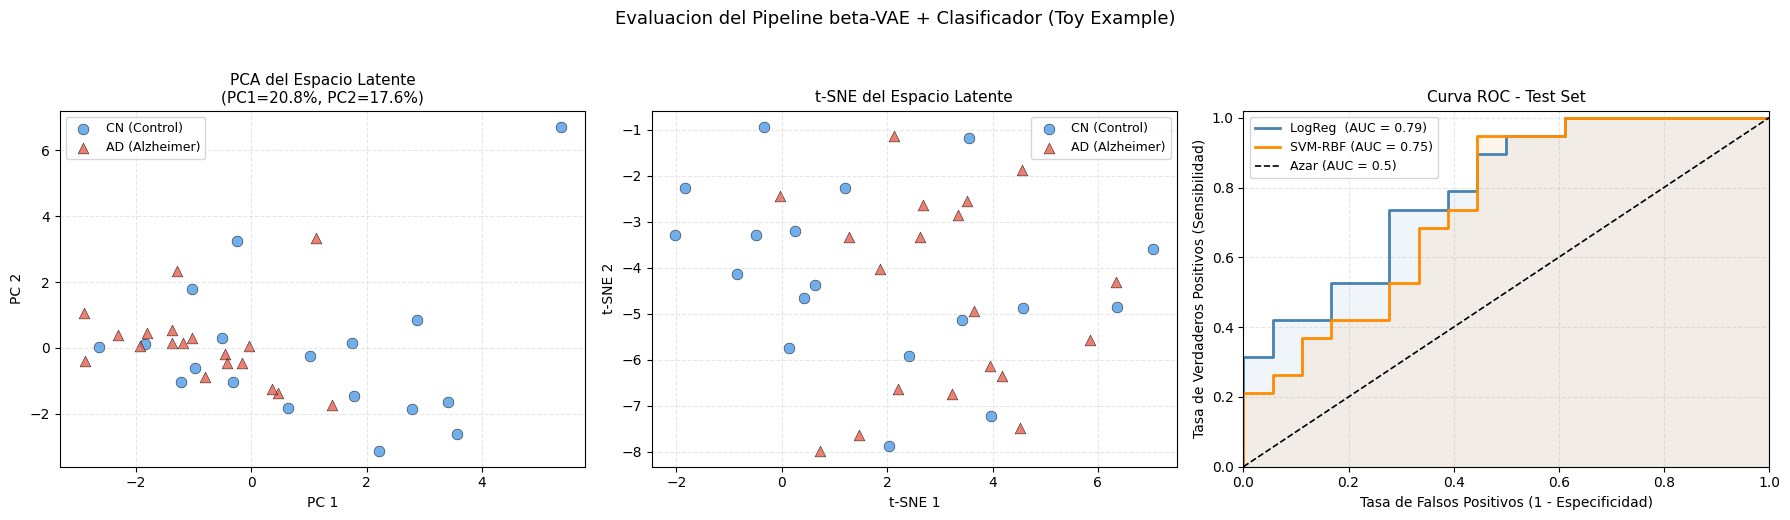

Figura guardada en betavae_results.png


In [9]:
# ── Proyecciones 2D ──────────────────────────────────────────────────────
pca  = PCA(n_components=2, random_state=SEED)
Z_pca = pca.fit_transform(Z_test_sc)
pca_var = pca.explained_variance_ratio_

tsne = TSNE(n_components=2, perplexity=15, random_state=SEED,
            max_iter=1000, verbose=0)
Z_tsne = tsne.fit_transform(Z_test_sc)

# ── Curvas ROC ────────────────────────────────────────────────────────────
fpr_lr, tpr_lr, _ = roc_curve(y_test_np, y_prob_lr)
fpr_sv, tpr_sv, _ = roc_curve(y_test_np, y_prob_sv)

# ── Figura compuesta ──────────────────────────────────────────────────────
fig = plt.figure(figsize=(18, 5))
gs  = gridspec.GridSpec(1, 3, figure=fig)

colors  = {0: '#4c9be8', 1: '#e8604c'}
labels  = {0: 'CN (Control)', 1: 'AD (Alzheimer)'}
markers = {0: 'o', 1: '^'}

# Panel 1: PCA
ax1 = fig.add_subplot(gs[0])
for cls in [0, 1]:
    mask = y_test_np == cls
    ax1.scatter(Z_pca[mask, 0], Z_pca[mask, 1], c=colors[cls],
                label=labels[cls], alpha=0.8, s=60, marker=markers[cls],
                edgecolors='k', linewidths=0.4)
ax1.set_title(
    f'PCA del Espacio Latente\n'
    f'(PC1={pca_var[0]:.1%}, PC2={pca_var[1]:.1%})', fontsize=11
)
ax1.set_xlabel('PC 1'); ax1.set_ylabel('PC 2')
ax1.legend(fontsize=9); ax1.grid(True, alpha=0.3, linestyle='--')

# Panel 2: t-SNE
ax2 = fig.add_subplot(gs[1])
for cls in [0, 1]:
    mask = y_test_np == cls
    ax2.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], c=colors[cls],
                label=labels[cls], alpha=0.8, s=60, marker=markers[cls],
                edgecolors='k', linewidths=0.4)
ax2.set_title('t-SNE del Espacio Latente', fontsize=11)
ax2.set_xlabel('t-SNE 1'); ax2.set_ylabel('t-SNE 2')
ax2.legend(fontsize=9); ax2.grid(True, alpha=0.3, linestyle='--')

# Panel 3: ROC
ax3 = fig.add_subplot(gs[2])
ax3.plot(fpr_lr, tpr_lr, lw=2, color='steelblue',
         label=f'LogReg  (AUC = {auc_lr:.2f})')
ax3.plot(fpr_sv, tpr_sv, lw=2, color='darkorange',
         label=f'SVM-RBF (AUC = {auc_sv:.2f})')
ax3.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Azar (AUC = 0.5)')
ax3.fill_between(fpr_lr, tpr_lr, alpha=0.08, color='steelblue')
ax3.fill_between(fpr_sv, tpr_sv, alpha=0.08, color='darkorange')
ax3.set_title('Curva ROC - Test Set', fontsize=11)
ax3.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
ax3.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
ax3.legend(fontsize=9); ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim([0, 1]); ax3.set_ylim([0, 1.02])

plt.suptitle(
    'Evaluacion del Pipeline beta-VAE + Clasificador (Toy Example)',
    fontsize=13, y=1.03
)
plt.tight_layout()
plt.savefig('betavae_results.png', dpi=120, bbox_inches='tight')
plt.show()
print('Figura guardada en betavae_results.png')


## 8. Resumen y Puntos Clave

### Pipeline completo

```
Datos brutos (1x64x64)
      |
      v
Normalizacion (Z-score por sujeto)
      |
      v
beta-VAE Encoder: CNN -> mu, log sigma^2
      |
      +--- Truco de Reparametrizacion: z = mu + sigma * eps
      |                    v
      |              beta-VAE Decoder: z -> x_hat
      |
      v
mu  (vector latente por sujeto, shape: latent_dim)
      |
      +--- StandardScaler
      |
      +--- Logistic Regression -> P(AD|mu)
      +--- SVM-RBF             -> P(AD|mu)
```

### Conceptos clave

| Concepto | Por qué importa |
|----------|-----------------|
| **β-VAE** | β > 1 fuerza un espacio latente más organizado (*disentangled*) |
| **Truco de reparametrización** | Permite backprop a través de muestreo estocástico |
| **μ vs z** | μ es más estable para clasificación (sin ruido de muestreo) |
| **Escalar con train only** | Evita data leakage hacia el test set |
| **AUC-ROC** | Métrica robusta a desbalance; independiente del umbral de decisión |

### Extensiones posibles

- Aumentar a **7 canales** (Pearson, MI, dFC, etc.) para aproximarse al paper original.
- Reemplazar el split 80/20 por **K-Fold estratificado** para estimar varianza del AUC.
- Agregar **LightGBM / XGBoost** como clasificadores adicionales.
- Implementar **SHAP** para interpretar qué dimensiones latentes impulsan la clasificación.
- Usar **programación cíclica de β** (β sube gradualmente en cada ciclo) para estabilizar el entrenamiento.

### Referencias

- Higgins, I. et al. (2017). *β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework*. ICLR 2017.
- Kingma, D. P. & Welling, M. (2013). *Auto-Encoding Variational Bayes*. arXiv:1312.6114.
- Paper original de este repositorio: *Explainable Latent Representation Learning for Alzheimer's Disease: A β-VAE and Saliency Map Framework*.
